In [8]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# custom functions
import utils


In [2]:
# load the dataset
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# convert y in 2D because commands will require it later
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


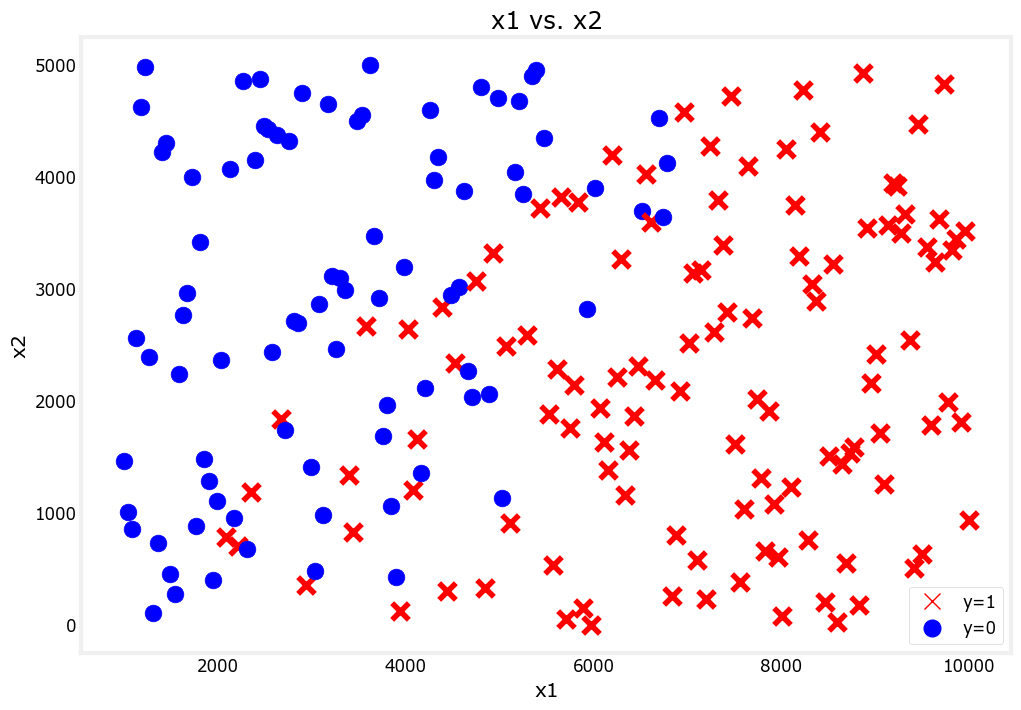

In [5]:
utils.plot_bc_dataset(x_bc, y_bc, "x1 vs. x2")

In [6]:
# split the dataset
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


### Evaluating the error for classification models

In the regression models, you used the mean squared error to measure how well your model is doing. For classification, you can get a similar metric by getting the fraction of the data that the model has misclassified. For example, if your model made wrong predictions for 2 samples out of 5, then you will report an error of `40%` or `0.4`. The code below demonstrates this using a for-loop and also with Numpy's [`mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function. 


In [7]:
# sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# initialize counter for misclassified data
misclassified = 0

# get number of predictions
num_predictions = len(predictions)

# loop over each prediction
for i in range(num_predictions):
    if predictions[i] != ground_truth[i]:
        misclassified += 1

fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build and train the model

You will use the same neural network architectures in the previous section so you can call the `build_models()` function again to create new instances of these models. 

You will follow the recommended approach mentioned last week where you use a `linear` activation for the output layer (instead of `sigmoid`) then set `from_logits=True` when declaring the loss function of the model. You will use the [binary crossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) because this is a binary classification problem.

After training, you will use a [sigmoid function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) to convert the model outputs into probabilities. From there, you can set a threshold and get the fraction of misclassified examples from the training and cross validation sets.

You can see all these in the code cell below.

In [12]:
# initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# build the models
models_bc = utils.build_bc_models()

for model in models_bc:
    # setup the loss and optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
    )

    print(f"training {model.name}...")

    # train the model
    model.fit(
        x_bc_train, y_bc_train,
        epochs = 400,
        verbose = 0
    )

    print("Done!\n")

    # set the threshold for classification
    threshold = 0.5

    # record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

training model_1_bc...


/Users/rohitdubey/Desktop/Projects/Personal/Machine Learning/ai-ml/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
training model_2_bc...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
training model_3_bc...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
Model 1: Training Set Classification Error: 0.41667, CV Set Classification Error: 0.47500
Model 2: Training Set Classification Error: 0.41667, CV Set Classification Error: 0.47500
Model 3: Training Set Classification Error: 0.41667, CV Set Classification Error: 0.47500


In [13]:
# select model with the lowest error
model_num = 2

# compute the test error
yhat = models_bc[model_num - 1].predict(x_bc_test)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= 0.5, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Selected Model: 2
Training Set Classification Error: 0.4167
CV Set Classification Error: 0.4750
Test Set Classification Error: 0.3750
